# PreTrain

In [1]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.429
[2] loss: 0.321
[3] loss: 0.148
[4] loss: 0.087
[5] loss: 0.055
[6] loss: 0.036
[7] loss: 0.027
[8] loss: 0.020
[9] loss: 0.016
[10] loss: 0.010
[11] loss: 0.010
[12] loss: 0.007
[13] loss: 0.009
[14] loss: 0.010
[15] loss: 0.004
[16] loss: 0.004
[17] loss: 0.004
[18] loss: 0.006
[19] loss: 0.003
[20] loss: 0.005
[21] loss: 0.003
[22] loss: 0.004
[23] loss: 0.003
[24] loss: 0.002
[25] loss: 0.001


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

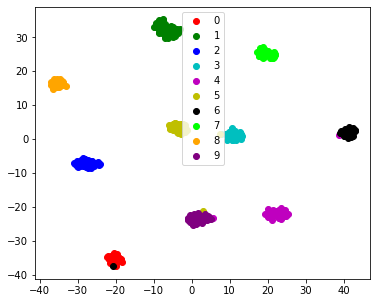

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

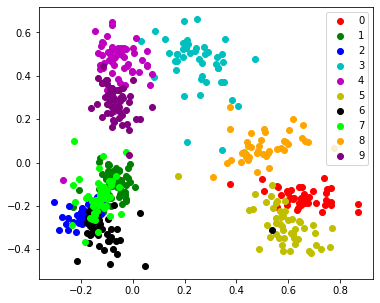

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [12]:
w = torch.Tensor(ys.transpose()/cs)
w

tensor([[ 0.6388, -0.0884, -0.1751,  0.2192, -0.0721,  0.5494, -0.1125, -0.1360,
          0.4976, -0.0826],
        [ 0.4453, -0.2081, -0.2839, -0.2304,  0.3685, -0.2509,  0.4192,  0.2891,
         -0.1840,  0.0563],
        [-0.1559, -0.1149, -0.2394,  0.4675,  0.4893, -0.2990, -0.2868, -0.1726,
          0.0629,  0.2949],
        [-0.1600,  0.4189, -0.2122, -0.1213,  0.1041, -0.1560, -0.1763,  0.5876,
          0.4729, -0.1803],
        [-0.2443, -0.1407, -0.2515,  0.0750, -0.2842,  0.5653,  0.1895,  0.2706,
         -0.1153,  0.6270],
        [-0.1432,  0.4275, -0.2384,  0.3786, -0.1260, -0.0107,  0.4784, -0.2148,
         -0.2461, -0.1733]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

# Train

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_11.cfg')

['./config/sswae_dev2_11.cfg']

In [6]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_{y_dim}.pt'))
mm.train()

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [001/100]  loss: 2.331780e-01  D: 6.926116e-01  D2: 4.844482e-02  D3: 4.577271e-03
test loss: 1.796295e-01  D: 6.997974e-01  D2: 2.519382e-02  D3: 1.072782e-02


[default |INFO|model.py:1280] [002/100]  loss: 1.698416e-01  D: 6.942218e-01  D2: 1.545282e-02  D3: 8.375187e-03
test loss: 1.568109e-01  D: 6.910134e-01  D2: 8.154840e-03  D3: 9.213909e-03


[default |INFO|model.py:1280] [003/100]  loss: 1.612440e-01  D: 7.255461e-01  D2: 5.682481e-03  D3: 1.377036e-02
test loss: 1.434864e-01  D: 6.796255e-01  D2: 4.809246e-03  D3: 1.070903e-02


[default |INFO|model.py:1280] [004/100]  loss: 1.247551e-01  D: 6.923325e-01  D2: 3.592397e-03  D3: 1.245432e-02
test loss: 1.164737e-01  D: 6.945245e-01  D2: 3.663216e-03  D3: 1.585841e-02


[default |INFO|model.py:1280] [005/100]  loss: 1.103463e-01  D: 6.950401e-01  D2: 1.171268e-03  D3: 1.489897e-02
test loss: 1.047589e-01  D: 6.873259e-01  D2: -1.962471e-04  D3: 1.616000e-02


[default |INFO|model.py:1280] [006/100]  loss: 9.706778e-02  D: 6.941302e-01  D2: -2.212779e-04  D3: 1.559652e-02
test loss: 9.210245e-02  D: 6.920716e-01  D2: -4.418373e-05  D3: 1.541508e-02


[default |INFO|model.py:1280] [007/100]  loss: 9.165718e-02  D: 6.937262e-01  D2: -6.791973e-04  D3: 1.572818e-02
test loss: 8.894374e-02  D: 7.005815e-01  D2: -6.091595e-04  D3: 1.592938e-02


[default |INFO|model.py:1280] [008/100]  loss: 8.667336e-02  D: 6.932656e-01  D2: -1.359641e-03  D3: 1.545341e-02
test loss: 8.535590e-02  D: 6.914611e-01  D2: -1.945925e-03  D3: 1.653710e-02


[default |INFO|model.py:1280] [009/100]  loss: 8.270087e-02  D: 6.939183e-01  D2: -3.278956e-03  D3: 1.507401e-02
test loss: 8.005319e-02  D: 7.090593e-01  D2: -4.285631e-03  D3: 1.410800e-02


[default |INFO|model.py:1280] [010/100]  loss: 7.949987e-02  D: 6.933816e-01  D2: -4.370173e-03  D3: 1.538941e-02
test loss: 7.833520e-02  D: 6.924295e-01  D2: -4.555407e-03  D3: 1.655591e-02


[default |INFO|model.py:1280] [011/100]  loss: 7.753275e-02  D: 6.942762e-01  D2: -5.055744e-03  D3: 1.497021e-02
test loss: 7.468274e-02  D: 6.924945e-01  D2: -5.116205e-03  D3: 1.420693e-02


[default |INFO|model.py:1280] [012/100]  loss: 7.512322e-02  D: 6.937260e-01  D2: -5.144285e-03  D3: 1.511251e-02
test loss: 7.209495e-02  D: 7.104690e-01  D2: -4.877281e-03  D3: 1.514572e-02


[default |INFO|model.py:1280] [013/100]  loss: 7.223019e-02  D: 6.932491e-01  D2: -5.459622e-03  D3: 1.503027e-02
test loss: 7.136585e-02  D: 6.876758e-01  D2: -5.030603e-03  D3: 1.652321e-02


[default |INFO|model.py:1280] [014/100]  loss: 7.130489e-02  D: 6.937267e-01  D2: -5.447117e-03  D3: 1.500841e-02
test loss: 7.130221e-02  D: 6.937180e-01  D2: -5.994616e-03  D3: 1.357253e-02


[default |INFO|model.py:1280] [015/100]  loss: 7.082408e-02  D: 6.935284e-01  D2: -5.903037e-03  D3: 1.452987e-02
test loss: 6.792865e-02  D: 7.038929e-01  D2: -5.968122e-03  D3: 1.557971e-02


[default |INFO|model.py:1280] [016/100]  loss: 6.850574e-02  D: 6.935701e-01  D2: -6.013691e-03  D3: 1.477718e-02
test loss: 6.808798e-02  D: 6.903465e-01  D2: -6.348391e-03  D3: 1.496386e-02


[default |INFO|model.py:1280] [017/100]  loss: 6.721671e-02  D: 6.932620e-01  D2: -6.375281e-03  D3: 1.473189e-02
test loss: 6.741279e-02  D: 6.966492e-01  D2: -6.060400e-03  D3: 1.346279e-02


[default |INFO|model.py:1280] [018/100]  loss: 6.660047e-02  D: 6.937232e-01  D2: -6.189159e-03  D3: 1.456134e-02
test loss: 6.571366e-02  D: 6.851568e-01  D2: -6.205606e-03  D3: 1.383456e-02


[default |INFO|model.py:1280] [019/100]  loss: 6.628044e-02  D: 6.933903e-01  D2: -6.323382e-03  D3: 1.435195e-02
test loss: 6.723857e-02  D: 7.016091e-01  D2: -5.159006e-03  D3: 1.230176e-02


[default |INFO|model.py:1280] [020/100]  loss: 6.475951e-02  D: 6.933556e-01  D2: -6.551019e-03  D3: 1.446421e-02
test loss: 6.689854e-02  D: 7.050342e-01  D2: -5.928144e-03  D3: 1.513975e-02


[default |INFO|model.py:1280] [021/100]  loss: 6.431566e-02  D: 6.935029e-01  D2: -6.672999e-03  D3: 1.431446e-02
test loss: 6.598248e-02  D: 6.952728e-01  D2: -7.186251e-03  D3: 1.382233e-02


[default |INFO|model.py:1280] [022/100]  loss: 6.401425e-02  D: 6.933180e-01  D2: -6.895866e-03  D3: 1.427242e-02
test loss: 6.485122e-02  D: 6.978514e-01  D2: -7.299204e-03  D3: 1.312721e-02


[default |INFO|model.py:1280] [023/100]  loss: 6.371589e-02  D: 6.934337e-01  D2: -6.989427e-03  D3: 1.417406e-02
test loss: 6.439054e-02  D: 6.989503e-01  D2: -6.909714e-03  D3: 1.427174e-02


[default |INFO|model.py:1280] [024/100]  loss: 6.305525e-02  D: 6.934075e-01  D2: -6.977798e-03  D3: 1.412802e-02
test loss: 6.351127e-02  D: 6.966371e-01  D2: -7.431278e-03  D3: 1.392357e-02


[default |INFO|model.py:1280] [025/100]  loss: 6.278924e-02  D: 6.929929e-01  D2: -7.527304e-03  D3: 1.396925e-02
test loss: 6.165796e-02  D: 6.879029e-01  D2: -7.208052e-03  D3: 1.375468e-02


[default |INFO|model.py:1280] [026/100]  loss: 6.232881e-02  D: 6.933579e-01  D2: -7.443220e-03  D3: 1.403894e-02
test loss: 6.269494e-02  D: 6.905124e-01  D2: -7.137699e-03  D3: 1.408878e-02


[default |INFO|model.py:1280] [027/100]  loss: 6.198205e-02  D: 6.935372e-01  D2: -7.264697e-03  D3: 1.406681e-02
test loss: 6.427601e-02  D: 6.856772e-01  D2: -7.538052e-03  D3: 1.315737e-02


[default |INFO|model.py:1280] [028/100]  loss: 6.192818e-02  D: 6.933016e-01  D2: -7.566614e-03  D3: 1.371535e-02
test loss: 6.340734e-02  D: 6.922905e-01  D2: -7.918406e-03  D3: 1.400650e-02


[default |INFO|model.py:1280] [029/100]  loss: 6.144272e-02  D: 6.937123e-01  D2: -7.691782e-03  D3: 1.378753e-02
test loss: 6.173448e-02  D: 6.884789e-01  D2: -7.917471e-03  D3: 1.468196e-02


[default |INFO|model.py:1280] [030/100]  loss: 6.091254e-02  D: 6.933221e-01  D2: -7.790526e-03  D3: 1.383037e-02
test loss: 6.174599e-02  D: 6.927622e-01  D2: -7.870131e-03  D3: 1.417329e-02


[default |INFO|model.py:1280] [031/100]  loss: 6.086696e-02  D: 6.930652e-01  D2: -7.811257e-03  D3: 1.378323e-02
test loss: 6.181308e-02  D: 6.952770e-01  D2: -7.889423e-03  D3: 1.413138e-02


[default |INFO|model.py:1280] [032/100]  loss: 6.066688e-02  D: 6.936999e-01  D2: -7.896323e-03  D3: 1.373648e-02
test loss: 6.276820e-02  D: 6.897170e-01  D2: -7.920008e-03  D3: 1.419383e-02


[default |INFO|model.py:1280] [033/100]  loss: 6.067357e-02  D: 6.931420e-01  D2: -7.891162e-03  D3: 1.363527e-02
test loss: 6.081867e-02  D: 6.975361e-01  D2: -7.886086e-03  D3: 1.366747e-02


[default |INFO|model.py:1280] [034/100]  loss: 5.988320e-02  D: 6.934129e-01  D2: -8.212132e-03  D3: 1.355619e-02
test loss: 6.369511e-02  D: 6.936395e-01  D2: -8.176603e-03  D3: 1.449594e-02


[default |INFO|model.py:1280] [035/100]  loss: 6.017458e-02  D: 6.936969e-01  D2: -8.231750e-03  D3: 1.354519e-02
test loss: 6.265060e-02  D: 6.933168e-01  D2: -8.534346e-03  D3: 1.416500e-02


[default |INFO|model.py:1280] [036/100]  loss: 6.077138e-02  D: 6.932804e-01  D2: -8.241385e-03  D3: 1.327378e-02
test loss: 6.155787e-02  D: 6.954539e-01  D2: -8.388090e-03  D3: 1.274714e-02


[default |INFO|model.py:1280] [037/100]  loss: 5.972938e-02  D: 6.932516e-01  D2: -8.311200e-03  D3: 1.349235e-02
test loss: 6.230633e-02  D: 6.935527e-01  D2: -8.448601e-03  D3: 1.408352e-02


[default |INFO|model.py:1280] [038/100]  loss: 6.004546e-02  D: 6.936744e-01  D2: -8.366144e-03  D3: 1.337553e-02
test loss: 6.418914e-02  D: 6.955591e-01  D2: -7.199173e-03  D3: 1.213484e-02


[default |INFO|model.py:1280] [039/100]  loss: 5.928792e-02  D: 6.930458e-01  D2: -8.572868e-03  D3: 1.334667e-02
test loss: 6.312359e-02  D: 6.987604e-01  D2: -8.809147e-03  D3: 1.241952e-02


[default |INFO|model.py:1280] [040/100]  loss: 5.894131e-02  D: 6.933769e-01  D2: -8.586386e-03  D3: 1.344742e-02
test loss: 6.087264e-02  D: 6.966468e-01  D2: -8.325672e-03  D3: 1.289171e-02


[default |INFO|model.py:1280] [041/100]  loss: 5.901435e-02  D: 6.936197e-01  D2: -8.692457e-03  D3: 1.337427e-02
test loss: 6.078333e-02  D: 6.881484e-01  D2: -9.021378e-03  D3: 1.341842e-02


[default |INFO|model.py:1280] [042/100]  loss: 5.880840e-02  D: 6.930985e-01  D2: -8.742361e-03  D3: 1.322199e-02
test loss: 6.035101e-02  D: 6.915620e-01  D2: -9.008694e-03  D3: 1.383617e-02


[default |INFO|model.py:1280] [043/100]  loss: 5.896030e-02  D: 6.934383e-01  D2: -8.857241e-03  D3: 1.315201e-02
test loss: 6.146542e-02  D: 6.978424e-01  D2: -9.075632e-03  D3: 1.187856e-02


[default |INFO|model.py:1280] [044/100]  loss: 5.894507e-02  D: 6.933014e-01  D2: -8.837582e-03  D3: 1.316136e-02
test loss: 5.924407e-02  D: 6.884504e-01  D2: -8.727093e-03  D3: 1.350485e-02


[default |INFO|model.py:1280] [045/100]  loss: 5.885432e-02  D: 6.935223e-01  D2: -8.935687e-03  D3: 1.308601e-02
test loss: 6.064532e-02  D: 6.906473e-01  D2: -8.682013e-03  D3: 1.355955e-02


[default |INFO|model.py:1280] [046/100]  loss: 5.912415e-02  D: 6.934695e-01  D2: -8.884509e-03  D3: 1.296526e-02
test loss: 6.230797e-02  D: 6.983156e-01  D2: -8.493395e-03  D3: 1.393497e-02


[default |INFO|model.py:1280] [047/100]  loss: 5.805375e-02  D: 6.933566e-01  D2: -9.055440e-03  D3: 1.307677e-02
test loss: 6.035935e-02  D: 6.941982e-01  D2: -8.806124e-03  D3: 1.372697e-02


[default |INFO|model.py:1280] [048/100]  loss: 5.820599e-02  D: 6.931996e-01  D2: -9.220832e-03  D3: 1.313527e-02
test loss: 5.959458e-02  D: 6.892227e-01  D2: -8.762264e-03  D3: 1.373087e-02


[default |INFO|model.py:1280] [049/100]  loss: 5.787973e-02  D: 6.933135e-01  D2: -9.198481e-03  D3: 1.300524e-02
test loss: 6.471231e-02  D: 6.889651e-01  D2: -8.817835e-03  D3: 1.160153e-02


[default |INFO|model.py:1280] [050/100]  loss: 5.837297e-02  D: 6.933613e-01  D2: -9.238764e-03  D3: 1.298831e-02
test loss: 6.234178e-02  D: 6.995666e-01  D2: -9.241390e-03  D3: 1.449019e-02


[default |INFO|model.py:1280] [051/100]  loss: 5.855370e-02  D: 6.931262e-01  D2: -9.325353e-03  D3: 1.294449e-02
test loss: 5.920536e-02  D: 6.994002e-01  D2: -9.540291e-03  D3: 1.301715e-02


[default |INFO|model.py:1280] [052/100]  loss: 5.783064e-02  D: 6.933523e-01  D2: -9.365449e-03  D3: 1.286495e-02
test loss: 5.987806e-02  D: 6.964984e-01  D2: -9.574738e-03  D3: 1.364355e-02


[default |INFO|model.py:1280] [053/100]  loss: 5.769232e-02  D: 6.932432e-01  D2: -9.402870e-03  D3: 1.290449e-02
test loss: 6.010341e-02  D: 6.962304e-01  D2: -9.647713e-03  D3: 1.314868e-02


[default |INFO|model.py:1280] [054/100]  loss: 5.772574e-02  D: 6.931851e-01  D2: -9.456490e-03  D3: 1.294748e-02
test loss: 5.902581e-02  D: 6.899232e-01  D2: -9.317236e-03  D3: 1.312225e-02


[default |INFO|model.py:1280] [055/100]  loss: 5.767098e-02  D: 6.933192e-01  D2: -9.543837e-03  D3: 1.283855e-02
test loss: 5.897323e-02  D: 6.954956e-01  D2: -9.574947e-03  D3: 1.242198e-02


[default |INFO|model.py:1280] [056/100]  loss: 5.736038e-02  D: 6.933976e-01  D2: -9.611929e-03  D3: 1.287583e-02
test loss: 5.933357e-02  D: 6.939736e-01  D2: -9.489965e-03  D3: 1.287833e-02


[default |INFO|model.py:1280] [057/100]  loss: 5.737286e-02  D: 6.930903e-01  D2: -9.609353e-03  D3: 1.292922e-02
test loss: 5.911859e-02  D: 6.933798e-01  D2: -9.512300e-03  D3: 1.337465e-02


[default |INFO|model.py:1280] [058/100]  loss: 5.759484e-02  D: 6.931712e-01  D2: -9.605640e-03  D3: 1.276056e-02
test loss: 5.847041e-02  D: 6.923422e-01  D2: -9.652767e-03  D3: 1.291712e-02


[default |INFO|model.py:1280] [059/100]  loss: 5.719661e-02  D: 6.933292e-01  D2: -9.754000e-03  D3: 1.274123e-02
test loss: 5.852823e-02  D: 6.962285e-01  D2: -9.092216e-03  D3: 1.348705e-02


[default |INFO|model.py:1280] [060/100]  loss: 5.729360e-02  D: 6.933251e-01  D2: -9.717433e-03  D3: 1.262239e-02
test loss: 5.854432e-02  D: 6.972106e-01  D2: -9.727545e-03  D3: 1.399501e-02


[default |INFO|model.py:1280] [061/100]  loss: 5.743816e-02  D: 6.932686e-01  D2: -9.724976e-03  D3: 1.265594e-02
test loss: 6.162851e-02  D: 6.941754e-01  D2: -9.787292e-03  D3: 1.175764e-02


[default |INFO|model.py:1280] [062/100]  loss: 5.729318e-02  D: 6.930854e-01  D2: -9.808877e-03  D3: 1.268581e-02
test loss: 5.827613e-02  D: 6.910191e-01  D2: -9.793568e-03  D3: 1.254846e-02


[default |INFO|model.py:1280] [063/100]  loss: 5.761925e-02  D: 6.928136e-01  D2: -9.879622e-03  D3: 1.246726e-02
test loss: 5.971987e-02  D: 6.915368e-01  D2: -9.620113e-03  D3: 1.157986e-02


[default |INFO|model.py:1280] [064/100]  loss: 5.690250e-02  D: 6.933792e-01  D2: -9.885681e-03  D3: 1.254505e-02
test loss: 5.900221e-02  D: 6.915897e-01  D2: -9.752340e-03  D3: 1.177249e-02


[default |INFO|model.py:1280] [065/100]  loss: 5.634717e-02  D: 6.933165e-01  D2: -9.969606e-03  D3: 1.267301e-02
test loss: 5.826830e-02  D: 6.913796e-01  D2: -1.021971e-02  D3: 1.225839e-02


[default |INFO|model.py:1280] [066/100]  loss: 5.626971e-02  D: 6.932138e-01  D2: -1.000624e-02  D3: 1.259356e-02
test loss: 5.921939e-02  D: 6.951657e-01  D2: -1.021236e-02  D3: 1.270981e-02


[default |INFO|model.py:1280] [067/100]  loss: 5.641251e-02  D: 6.931541e-01  D2: -1.007174e-02  D3: 1.260881e-02
test loss: 5.891835e-02  D: 6.961018e-01  D2: -9.997435e-03  D3: 1.265686e-02


[default |INFO|model.py:1280] [068/100]  loss: 5.653198e-02  D: 6.932243e-01  D2: -9.999757e-03  D3: 1.260425e-02
test loss: 5.951667e-02  D: 6.941327e-01  D2: -9.489155e-03  D3: 1.256522e-02


[default |INFO|model.py:1280] [069/100]  loss: 5.621739e-02  D: 6.929935e-01  D2: -1.009777e-02  D3: 1.250127e-02
test loss: 5.926909e-02  D: 6.927255e-01  D2: -9.951859e-03  D3: 1.264820e-02


[default |INFO|model.py:1280] [070/100]  loss: 5.676609e-02  D: 6.931853e-01  D2: -1.011080e-02  D3: 1.247794e-02
test loss: 5.925355e-02  D: 6.919704e-01  D2: -1.007332e-02  D3: 1.268060e-02


[default |INFO|model.py:1280] [071/100]  loss: 5.638085e-02  D: 6.932487e-01  D2: -1.012931e-02  D3: 1.253236e-02
test loss: 5.978804e-02  D: 6.908632e-01  D2: -1.030421e-02  D3: 1.201555e-02


[default |INFO|model.py:1280] [072/100]  loss: 5.671805e-02  D: 6.932025e-01  D2: -1.016723e-02  D3: 1.244472e-02
test loss: 5.970850e-02  D: 6.935722e-01  D2: -1.008993e-02  D3: 1.217872e-02


[default |INFO|model.py:1280] [073/100]  loss: 5.609193e-02  D: 6.931854e-01  D2: -1.019284e-02  D3: 1.241442e-02
test loss: 5.830250e-02  D: 6.935332e-01  D2: -1.017071e-02  D3: 1.214042e-02


[default |INFO|model.py:1280] [074/100]  loss: 5.583815e-02  D: 6.931461e-01  D2: -1.018955e-02  D3: 1.236797e-02
test loss: 5.970841e-02  D: 6.957346e-01  D2: -1.021134e-02  D3: 1.277646e-02


[default |INFO|model.py:1280] [075/100]  loss: 5.595916e-02  D: 6.932034e-01  D2: -1.027605e-02  D3: 1.244359e-02
test loss: 5.916757e-02  D: 6.927244e-01  D2: -1.041786e-02  D3: 1.201460e-02


[default |INFO|model.py:1280] [076/100]  loss: 5.595562e-02  D: 6.931758e-01  D2: -1.026903e-02  D3: 1.234097e-02
test loss: 5.926714e-02  D: 6.964840e-01  D2: -9.804049e-03  D3: 1.217433e-02


[default |INFO|model.py:1280] [077/100]  loss: 5.597190e-02  D: 6.932439e-01  D2: -1.025816e-02  D3: 1.233182e-02
test loss: 5.714895e-02  D: 6.929113e-01  D2: -1.031796e-02  D3: 1.251902e-02


[default |INFO|model.py:1280] [078/100]  loss: 5.546993e-02  D: 6.932308e-01  D2: -1.037747e-02  D3: 1.230335e-02
test loss: 5.814777e-02  D: 6.941209e-01  D2: -1.042078e-02  D3: 1.295123e-02


[default |INFO|model.py:1280] [079/100]  loss: 5.588663e-02  D: 6.931155e-01  D2: -1.033879e-02  D3: 1.231179e-02
test loss: 5.954706e-02  D: 6.929954e-01  D2: -1.049053e-02  D3: 1.268391e-02


[default |INFO|model.py:1280] [080/100]  loss: 5.545388e-02  D: 6.932342e-01  D2: -1.044601e-02  D3: 1.224745e-02
test loss: 5.851133e-02  D: 6.891843e-01  D2: -1.021486e-02  D3: 1.216101e-02


[default |INFO|model.py:1280] [081/100]  loss: 5.554607e-02  D: 6.930869e-01  D2: -1.037560e-02  D3: 1.225868e-02
test loss: 5.844859e-02  D: 6.908204e-01  D2: -1.042749e-02  D3: 1.254908e-02


[default |INFO|model.py:1280] [082/100]  loss: 5.551665e-02  D: 6.933489e-01  D2: -1.041449e-02  D3: 1.219020e-02
test loss: 5.743219e-02  D: 6.930694e-01  D2: -1.043253e-02  D3: 1.232545e-02


[default |INFO|model.py:1280] [083/100]  loss: 5.500400e-02  D: 6.931770e-01  D2: -1.051274e-02  D3: 1.227046e-02
test loss: 5.737622e-02  D: 6.953406e-01  D2: -1.049132e-02  D3: 1.190892e-02


[default |INFO|model.py:1280] [084/100]  loss: 5.525024e-02  D: 6.930230e-01  D2: -1.045959e-02  D3: 1.219420e-02
test loss: 5.795594e-02  D: 6.915835e-01  D2: -1.053174e-02  D3: 1.174891e-02


[default |INFO|model.py:1280] [085/100]  loss: 5.542041e-02  D: 6.932126e-01  D2: -1.051983e-02  D3: 1.211711e-02
test loss: 5.808283e-02  D: 6.935499e-01  D2: -1.049131e-02  D3: 1.212840e-02


[default |INFO|model.py:1280] [086/100]  loss: 5.556176e-02  D: 6.932196e-01  D2: -1.049323e-02  D3: 1.201614e-02
test loss: 5.817168e-02  D: 6.956866e-01  D2: -1.053600e-02  D3: 1.212489e-02


[default |INFO|model.py:1280] [087/100]  loss: 5.551688e-02  D: 6.932403e-01  D2: -1.050573e-02  D3: 1.200757e-02
test loss: 5.842899e-02  D: 6.943166e-01  D2: -1.047479e-02  D3: 1.158155e-02


[default |INFO|model.py:1280] [088/100]  loss: 5.489592e-02  D: 6.931707e-01  D2: -1.062289e-02  D3: 1.203455e-02
test loss: 5.845635e-02  D: 6.938386e-01  D2: -1.074018e-02  D3: 1.237994e-02


[default |INFO|model.py:1280] [089/100]  loss: 5.545796e-02  D: 6.932772e-01  D2: -1.060969e-02  D3: 1.206234e-02
test loss: 5.795830e-02  D: 6.945312e-01  D2: -1.061197e-02  D3: 1.200280e-02


[default |INFO|model.py:1280] [090/100]  loss: 5.547186e-02  D: 6.930527e-01  D2: -1.049711e-02  D3: 1.205967e-02
test loss: 5.779048e-02  D: 6.925794e-01  D2: -1.057369e-02  D3: 1.220176e-02


[default |INFO|model.py:1280] [091/100]  loss: 5.514423e-02  D: 6.932988e-01  D2: -1.067282e-02  D3: 1.203051e-02
test loss: 5.799464e-02  D: 6.952889e-01  D2: -1.055944e-02  D3: 1.253334e-02


[default |INFO|model.py:1280] [092/100]  loss: 5.496889e-02  D: 6.930674e-01  D2: -1.060486e-02  D3: 1.206614e-02
test loss: 5.816195e-02  D: 6.910770e-01  D2: -1.056762e-02  D3: 1.243060e-02


[default |INFO|model.py:1280] [093/100]  loss: 5.507616e-02  D: 6.930894e-01  D2: -1.063365e-02  D3: 1.191694e-02
test loss: 5.803288e-02  D: 6.886859e-01  D2: -1.064248e-02  D3: 1.215417e-02


[default |INFO|model.py:1280] [094/100]  loss: 5.492353e-02  D: 6.933615e-01  D2: -1.065181e-02  D3: 1.190506e-02
test loss: 5.799084e-02  D: 6.902625e-01  D2: -1.031692e-02  D3: 1.139338e-02


[default |INFO|model.py:1280] [095/100]  loss: 5.522223e-02  D: 6.933141e-01  D2: -1.061330e-02  D3: 1.192372e-02
test loss: 5.758694e-02  D: 6.974517e-01  D2: -1.058644e-02  D3: 1.196065e-02


[default |INFO|model.py:1280] [096/100]  loss: 5.505375e-02  D: 6.930535e-01  D2: -1.073716e-02  D3: 1.188721e-02
test loss: 5.803250e-02  D: 6.978884e-01  D2: -1.067349e-02  D3: 1.231929e-02


[default |INFO|model.py:1280] [097/100]  loss: 5.471912e-02  D: 6.933267e-01  D2: -1.070024e-02  D3: 1.184532e-02
test loss: 5.854830e-02  D: 6.898089e-01  D2: -1.083591e-02  D3: 1.124053e-02


[default |INFO|model.py:1280] [098/100]  loss: 5.483589e-02  D: 6.930766e-01  D2: -1.068959e-02  D3: 1.182458e-02
test loss: 5.775349e-02  D: 6.937936e-01  D2: -1.068502e-02  D3: 1.131397e-02


[default |INFO|model.py:1280] [099/100]  loss: 5.427172e-02  D: 6.932189e-01  D2: -1.070676e-02  D3: 1.180797e-02
test loss: 5.781095e-02  D: 6.916887e-01  D2: -1.077963e-02  D3: 1.157575e-02


[default |INFO|model.py:1280] [100/100]  loss: 5.423581e-02  D: 6.931553e-01  D2: -1.076124e-02  D3: 1.192968e-02
test loss: 5.820524e-02  D: 6.907950e-01  D2: -1.060513e-02  D3: 1.137947e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3696.838s


# Test

In [7]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [8]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [9]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[np.random.choice(target_d.shape[0], 1, replace = False)])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

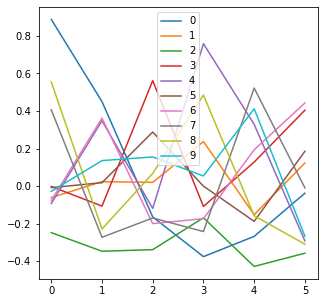

In [10]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

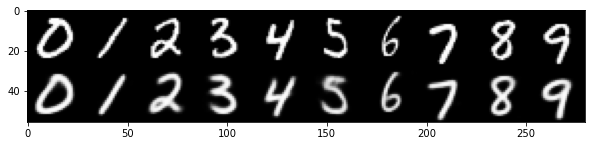

In [11]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [12]:
exn = 5

In [13]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

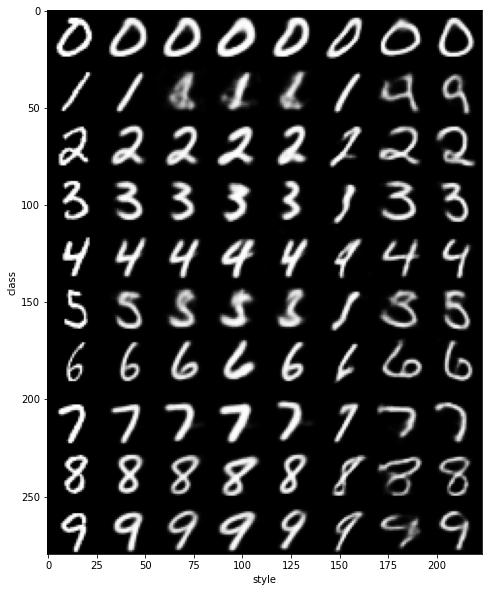

In [14]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [24]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

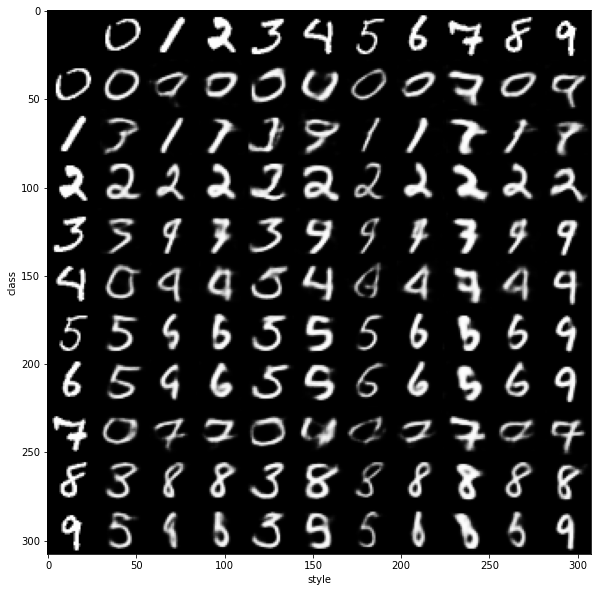

In [25]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()